## 1. Environment Setup and Imports

In [63]:
# Core libraries
import os
import sys
import random
import shutil
import glob
import json
import pickle
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

# PyTorch ecosystem
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Machine learning and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memory: 6.0 GB


## 2. Dataset Preparation

### Configuration and Paths

In [39]:
# Dataset configuration
BASE_DIR = Path(r'c:\Users\Ammad\Documents\Projects\Personal\Brain2')
MRI_SOURCE_DIR = BASE_DIR / 'MRI' / 'tumor'
BREAST_SOURCE_DIR = BASE_DIR / 'BreastHisto'

# Output directories for processed dataset
PROCESSED_DATA_DIR = BASE_DIR / 'processed_data'
MRI_PROCESSED_DIR = PROCESSED_DATA_DIR / 'MRI'
BREAST_PROCESSED_DIR = PROCESSED_DATA_DIR / 'BreastHisto'

# Model and results directories
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'

# Create directories
for dir_path in [PROCESSED_DATA_DIR, MRI_PROCESSED_DIR, BREAST_PROCESSED_DIR, MODELS_DIR, RESULTS_DIR]:
    dir_path.mkdir(exist_ok=True, parents=True)

# Dataset configuration
BREAST_SAMPLES_PER_CLASS = 5000  # Sample 5000 from each class (0 and 1)
TARGET_IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_WORKERS = 0

print(f"Base directory: {BASE_DIR}")
print(f"MRI source: {MRI_SOURCE_DIR}")
print(f"Breast source: {BREAST_SOURCE_DIR}")
print(f"Processed data will be saved to: {PROCESSED_DATA_DIR}")

Base directory: c:\Users\Ammad\Documents\Projects\Personal\Brain2
MRI source: c:\Users\Ammad\Documents\Projects\Personal\Brain2\MRI\tumor
Breast source: c:\Users\Ammad\Documents\Projects\Personal\Brain2\BreastHisto
Processed data will be saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\processed_data


### Analyze Dataset Structure

In [40]:
def analyze_dataset_structure():
    """Analyze the structure of both datasets"""
    print("=== DATASET STRUCTURE ANALYSIS ===")
    
    # Analyze MRI dataset
    print("\n📁 MRI Dataset Structure:")
    mri_stats = {}
    
    if MRI_SOURCE_DIR.exists():
        for tumor_type in MRI_SOURCE_DIR.iterdir():
            if tumor_type.is_dir():
                image_files = list(tumor_type.glob('*.jpg')) + list(tumor_type.glob('*.png'))
                mri_stats[tumor_type.name] = len(image_files)
                print(f"  {tumor_type.name}: {len(image_files)} images")
    
    total_mri = sum(mri_stats.values())
    print(f"  📊 Total MRI images: {total_mri}")
    
    # Analyze Breast Histopathology dataset
    print("\n📁 Breast Histopathology Dataset Structure:")
    breast_stats = {'class_0': 0, 'class_1': 0}
    
    if BREAST_SOURCE_DIR.exists():
        # Count samples by examining first few patient directories
        sample_dirs = list(BREAST_SOURCE_DIR.iterdir())[:5]  # Sample first 5 for speed
        
        class_0_sample = 0
        class_1_sample = 0
        
        for patient_dir in sample_dirs:
            if patient_dir.is_dir() and patient_dir.name.isdigit():
                class_0_dir = patient_dir / '0'
                class_1_dir = patient_dir / '1'
                
                if class_0_dir.exists():
                    class_0_sample += len(list(class_0_dir.glob('*.png')))
                if class_1_dir.exists():
                    class_1_sample += len(list(class_1_dir.glob('*.png')))
        
        # Estimate total based on sample
        total_patient_dirs = len([d for d in BREAST_SOURCE_DIR.iterdir() if d.is_dir() and d.name.isdigit()])
        
        if len(sample_dirs) > 0:
            estimated_class_0 = (class_0_sample * total_patient_dirs) // len(sample_dirs)
            estimated_class_1 = (class_1_sample * total_patient_dirs) // len(sample_dirs)
            
            print(f"  📊 Patient directories found: {total_patient_dirs}")
            print(f"  📊 Estimated class 0 (benign): ~{estimated_class_0:,} images")
            print(f"  📊 Estimated class 1 (malignant): ~{estimated_class_1:,} images")
            print(f"  📊 Total estimated: ~{estimated_class_0 + estimated_class_1:,} images")
    
    return mri_stats, total_mri

mri_stats, total_mri_images = analyze_dataset_structure()

=== DATASET STRUCTURE ANALYSIS ===

📁 MRI Dataset Structure:
  glioma_tumor: 926 images
  meningioma_tumor: 937 images
  no_tumor: 500 images
  pituitary_tumor: 901 images
  📊 Total MRI images: 3264

📁 Breast Histopathology Dataset Structure:
  📊 Patient directories found: 279
  📊 Estimated class 0 (benign): ~123,318 images
  📊 Estimated class 1 (malignant): ~31,359 images
  📊 Total estimated: ~154,677 images


### Process MRI Dataset

Flatten all MRI tumor types into a single 'MRI' class

In [41]:
def process_mri_dataset():
    """Process MRI dataset by flattening all tumor types into single MRI class"""
    print("\n🔄 Processing MRI Dataset...")
    
    # Clear existing processed MRI data
    if MRI_PROCESSED_DIR.exists():
        shutil.rmtree(MRI_PROCESSED_DIR)
    MRI_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    
    mri_files = []
    processed_count = 0
    
    # Collect all MRI images from all tumor types
    for tumor_type_dir in MRI_SOURCE_DIR.iterdir():
        if tumor_type_dir.is_dir():
            tumor_type = tumor_type_dir.name
            print(f"  Processing {tumor_type}...")
            
            # Find all image files
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
            tumor_images = []
            
            for ext in image_extensions:
                tumor_images.extend(list(tumor_type_dir.glob(ext)))
            
            # Copy images to processed directory with new naming
            for i, img_path in enumerate(tqdm(tumor_images, desc=f"  Copying {tumor_type}")):
                # Create new filename: mri_tumortype_originalname
                new_filename = f"mri_{tumor_type}_{img_path.stem}{img_path.suffix}"
                new_path = MRI_PROCESSED_DIR / new_filename
                
                # Copy file
                shutil.copy2(img_path, new_path)
                mri_files.append(str(new_path))
                processed_count += 1
    
    print(f"  ✅ Processed {processed_count} MRI images")
    print(f"  📁 Saved to: {MRI_PROCESSED_DIR}")
    
    return mri_files

# Process MRI dataset
mri_file_list = process_mri_dataset()


🔄 Processing MRI Dataset...
  Processing glioma_tumor...
  Processing glioma_tumor...


  Copying glioma_tumor: 100%|██████████| 926/926 [00:02<00:00, 323.09it/s]


  Processing meningioma_tumor...


  Copying meningioma_tumor: 100%|██████████| 937/937 [00:02<00:00, 359.13it/s]


  Processing no_tumor...


  Copying no_tumor: 100%|██████████| 500/500 [00:01<00:00, 382.67it/s]


  Processing pituitary_tumor...


  Copying pituitary_tumor: 100%|██████████| 901/901 [00:02<00:00, 379.30it/s]

  ✅ Processed 3264 MRI images
  📁 Saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\processed_data\MRI


### Process Breast Histopathology Dataset

Sample and flatten breast histopathology images (5000 from each class)

In [42]:
def process_breast_dataset():
    """Process Breast Histopathology dataset by sampling and flattening structure"""
    print("\n🔄 Processing Breast Histopathology Dataset...")
    
    # Clear existing processed breast data
    if BREAST_PROCESSED_DIR.exists():
        shutil.rmtree(BREAST_PROCESSED_DIR)
    BREAST_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    
    breast_files = []
    class_counts = {'class_0': 0, 'class_1': 0}
    
    # Collect all images from both classes
    all_class_0_images = []
    all_class_1_images = []
    
    print("  📊 Collecting all breast histopathology images...")
    
    # Iterate through patient directories
    patient_dirs = [d for d in BREAST_SOURCE_DIR.iterdir() 
                   if d.is_dir() and d.name.isdigit()]
    
    for patient_dir in tqdm(patient_dirs, desc="  Scanning patient directories"):
        # Class 0 (benign)
        class_0_dir = patient_dir / '0'
        if class_0_dir.exists():
            class_0_images = list(class_0_dir.glob('*.png'))
            all_class_0_images.extend([(img, patient_dir.name) for img in class_0_images])
        
        # Class 1 (malignant) 
        class_1_dir = patient_dir / '1'
        if class_1_dir.exists():
            class_1_images = list(class_1_dir.glob('*.png'))
            all_class_1_images.extend([(img, patient_dir.name) for img in class_1_images])
    
    print(f"  📊 Found {len(all_class_0_images):,} class 0 images")
    print(f"  📊 Found {len(all_class_1_images):,} class 1 images")
    
    # Sample images from each class
    print(f"  🎯 Sampling {BREAST_SAMPLES_PER_CLASS:,} images from each class...")
    
    # Randomly sample class 0
    if len(all_class_0_images) >= BREAST_SAMPLES_PER_CLASS:
        sampled_class_0 = random.sample(all_class_0_images, BREAST_SAMPLES_PER_CLASS)
    else:
        sampled_class_0 = all_class_0_images
        print(f"  ⚠️  Only {len(all_class_0_images)} class 0 images available")
    
    # Randomly sample class 1
    if len(all_class_1_images) >= BREAST_SAMPLES_PER_CLASS:
        sampled_class_1 = random.sample(all_class_1_images, BREAST_SAMPLES_PER_CLASS)
    else:
        sampled_class_1 = all_class_1_images
        print(f"  ⚠️  Only {len(all_class_1_images)} class 1 images available")
    
    # Copy sampled images
    print("  📁 Copying sampled images...")
    
    # Process class 0 samples
    for i, (img_path, patient_id) in enumerate(tqdm(sampled_class_0, desc="  Class 0")):
        new_filename = f"breast_class0_patient{patient_id}_{i:05d}.png"
        new_path = BREAST_PROCESSED_DIR / new_filename
        shutil.copy2(img_path, new_path)
        breast_files.append(str(new_path))
        class_counts['class_0'] += 1
    
    # Process class 1 samples
    for i, (img_path, patient_id) in enumerate(tqdm(sampled_class_1, desc="  Class 1")):
        new_filename = f"breast_class1_patient{patient_id}_{i:05d}.png"
        new_path = BREAST_PROCESSED_DIR / new_filename
        shutil.copy2(img_path, new_path)
        breast_files.append(str(new_path))
        class_counts['class_1'] += 1
    
    total_breast = sum(class_counts.values())
    print(f"  ✅ Processed {total_breast} breast histopathology images")
    print(f"     - Class 0 (benign): {class_counts['class_0']}")
    print(f"     - Class 1 (malignant): {class_counts['class_1']}")
    print(f"  📁 Saved to: {BREAST_PROCESSED_DIR}")
    
    return breast_files, class_counts

# Process Breast Histopathology dataset
breast_file_list, breast_class_counts = process_breast_dataset()


🔄 Processing Breast Histopathology Dataset...
  📊 Collecting all breast histopathology images...
  📊 Collecting all breast histopathology images...


  Scanning patient directories: 100%|██████████| 279/279 [00:02<00:00, 94.91it/s] 


  📊 Found 198,738 class 0 images
  📊 Found 78,786 class 1 images
  🎯 Sampling 5,000 images from each class...
  📁 Copying sampled images...


  Class 1: 100%|██████████| 5000/5000 [00:07<00:00, 683.98it/s]


  ✅ Processed 10000 breast histopathology images
     - Class 0 (benign): 5000
     - Class 1 (malignant): 5000
  📁 Saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\processed_data\BreastHisto


### Create Final Dataset Structure

Combine both datasets into final binary classification structure

In [43]:
def create_final_dataset():
    """Create final dataset with labels for binary classification"""
    print("\n🎯 Creating Final Dataset Structure...")
    
    # Create dataset info
    dataset_info = {
        'classes': ['MRI', 'BreastHisto'],
        'class_to_idx': {'MRI': 0, 'BreastHisto': 1},
        'idx_to_class': {0: 'MRI', 1: 'BreastHisto'}
    }
    
    # Create file list with labels
    all_files = []
    all_labels = []
    
    # Add MRI files (label 0)
    for file_path in mri_file_list:
        all_files.append(file_path)
        all_labels.append(0)  # MRI = 0
    
    # Add Breast Histopathology files (label 1)
    for file_path in breast_file_list:
        all_files.append(file_path)
        all_labels.append(1)  # BreastHisto = 1
    
    # Create dataset DataFrame
    dataset_df = pd.DataFrame({
        'file_path': all_files,
        'label': all_labels,
        'class_name': [dataset_info['idx_to_class'][label] for label in all_labels]
    })
    
    # Shuffle the dataset
    dataset_df = dataset_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    # Save dataset info and file list
    dataset_info_path = PROCESSED_DATA_DIR / 'dataset_info.json'
    dataset_df_path = PROCESSED_DATA_DIR / 'dataset.csv'
    
    with open(dataset_info_path, 'w') as f:
        json.dump(dataset_info, f, indent=2)
    
    dataset_df.to_csv(dataset_df_path, index=False)
    
    # Print dataset statistics
    class_counts = dataset_df['class_name'].value_counts()
    print(f"\n📊 Final Dataset Statistics:")
    print(f"  Total images: {len(dataset_df):,}")
    for class_name, count in class_counts.items():
        percentage = (count / len(dataset_df)) * 100
        print(f"  {class_name}: {count:,} images ({percentage:.1f}%)")
    
    print(f"\n📁 Dataset saved to:")
    print(f"  Info: {dataset_info_path}")
    print(f"  Files: {dataset_df_path}")
    
    return dataset_df, dataset_info

# Create final dataset
dataset_df, dataset_info = create_final_dataset()
print("\n✅ Dataset preparation completed!")


🎯 Creating Final Dataset Structure...

📊 Final Dataset Statistics:
  Total images: 13,264
  BreastHisto: 10,000 images (75.4%)
  MRI: 3,264 images (24.6%)

📁 Dataset saved to:
  Info: c:\Users\Ammad\Documents\Projects\Personal\Brain2\processed_data\dataset_info.json
  Files: c:\Users\Ammad\Documents\Projects\Personal\Brain2\processed_data\dataset.csv

✅ Dataset preparation completed!


## 3. Data Handling

### Data Splitting Strategy

In [44]:
def create_data_splits(dataset_df, test_size=0.2, val_size=0.2):
    """Create train/validation/test splits with no data leakage"""
    print("\n📊 Creating Train/Validation/Test Splits...")
    
    # First split: train+val vs test
    train_val_df, test_df = train_test_split(
        dataset_df, 
        test_size=test_size, 
        stratify=dataset_df['label'],
        random_state=RANDOM_SEED
    )
    
    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)  # Adjust val_size for remaining data
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size_adjusted,
        stratify=train_val_df['label'],
        random_state=RANDOM_SEED
    )
    
    # Verify no overlap between splits
    train_files = set(train_df['file_path'])
    val_files = set(val_df['file_path'])
    test_files = set(test_df['file_path'])
    
    assert len(train_files.intersection(val_files)) == 0, "Train/Val overlap detected!"
    assert len(train_files.intersection(test_files)) == 0, "Train/Test overlap detected!"
    assert len(val_files.intersection(test_files)) == 0, "Val/Test overlap detected!"
    
    print(f"✅ No data leakage detected between splits")
    
    # Print split statistics
    splits_info = {
        'train': train_df,
        'val': val_df,
        'test': test_df
    }
    
    print(f"\n📊 Split Statistics:")
    for split_name, split_df in splits_info.items():
        total = len(split_df)
        class_counts = split_df['class_name'].value_counts()
        print(f"\n  {split_name.upper()} SET ({total:,} images):")
        for class_name, count in class_counts.items():
            percentage = (count / total) * 100
            print(f"    {class_name}: {count:,} ({percentage:.1f}%)")
    
    # Save splits
    splits_dir = PROCESSED_DATA_DIR / 'splits'
    splits_dir.mkdir(exist_ok=True)
    
    train_df.to_csv(splits_dir / 'train.csv', index=False)
    val_df.to_csv(splits_dir / 'val.csv', index=False)
    test_df.to_csv(splits_dir / 'test.csv', index=False)
    
    print(f"\n📁 Splits saved to: {splits_dir}")
    
    return train_df, val_df, test_df

# Create data splits
train_df, val_df, test_df = create_data_splits(dataset_df)


📊 Creating Train/Validation/Test Splits...
✅ No data leakage detected between splits

📊 Split Statistics:

  TRAIN SET (7,958 images):
    BreastHisto: 6,000 (75.4%)
    MRI: 1,958 (24.6%)

  VAL SET (2,653 images):
    BreastHisto: 2,000 (75.4%)
    MRI: 653 (24.6%)

  TEST SET (2,653 images):
    BreastHisto: 2,000 (75.4%)
    MRI: 653 (24.6%)

📁 Splits saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\processed_data\splits


### Image Preprocessing and Transformations

In [45]:
def get_image_transforms():
    """Define image transformations for training and validation"""
    
    # ImageNet normalization values
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    # Training transforms (with augmentation)
    train_transforms = transforms.Compose([
        transforms.Resize(TARGET_IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    
    # Validation/Test transforms (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize(TARGET_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    
    return train_transforms, val_transforms

# Get transforms
train_transforms, val_transforms = get_image_transforms()
print("✅ Image transformations defined")
print(f"  Target size: {TARGET_IMAGE_SIZE}")
print(f"  Training augmentations: Flip, Rotation, ColorJitter")
print(f"  Normalization: ImageNet mean/std")

✅ Image transformations defined
  Target size: (224, 224)
  Training augmentations: Flip, Rotation, ColorJitter
  Normalization: ImageNet mean/std


### Custom Dataset Class

In [46]:
class MedicalImageDataset(Dataset):
    """Custom Dataset class for medical images with proper preprocessing"""
    
    def __init__(self, dataframe, transform=None, class_to_idx=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx or {'MRI': 0, 'BreastHisto': 1}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get image path and label
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        label = row['label']
        
        # Load image
        try:
            image = Image.open(img_path)
            
            # Convert grayscale to RGB if needed
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            fallback_image = Image.new('RGB', TARGET_IMAGE_SIZE, (0, 0, 0))
            if self.transform:
                fallback_image = self.transform(fallback_image)
            return fallback_image, label
    
    def get_class_distribution(self):
        """Get class distribution for the dataset"""
        return self.dataframe['label'].value_counts().sort_index()

# Test dataset creation
print("✅ Custom Dataset class defined")
print("Features:")
print("  - Automatic grayscale to RGB conversion")
print("  - Error handling for corrupted images")
print("  - Class distribution analysis")
print("  - Consistent preprocessing pipeline")

✅ Custom Dataset class defined
Features:
  - Automatic grayscale to RGB conversion
  - Error handling for corrupted images
  - Class distribution analysis
  - Consistent preprocessing pipeline


### Calculate Class Weights and Create DataLoaders

In [47]:
def calculate_class_weights(train_df):
    """Calculate class weights for handling imbalanced dataset"""
    class_counts = train_df['label'].value_counts().sort_index()
    total_samples = len(train_df)
    
    print("\n⚖️  Class Balance Analysis:")
    for class_idx, count in class_counts.items():
        class_name = dataset_info['idx_to_class'][class_idx]
        percentage = (count / total_samples) * 100
        print(f"  Class {class_idx} ({class_name}): {count:,} samples ({percentage:.1f}%)")
    
    # Calculate weights: inverse frequency
    class_weights = total_samples / (len(class_counts) * class_counts.values)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print(f"\n📊 Calculated Class Weights:")
    for class_idx, weight in class_weights_dict.items():
        class_name = dataset_info['idx_to_class'][class_idx]
        print(f"  Class {class_idx} ({class_name}): {weight:.3f}")
    
    # Create sample weights for WeightedRandomSampler
    sample_weights = [class_weights_dict[label] for label in train_df['label']]
    
    return class_weights_dict, sample_weights

def create_data_loaders(train_df, val_df, test_df):
    """Create DataLoaders with proper sampling for class imbalance"""
    print("\n🔄 Creating DataLoaders...")
    
    # Calculate class weights
    class_weights_dict, sample_weights = calculate_class_weights(train_df)
    
    # Create datasets
    train_dataset = MedicalImageDataset(train_df, transform=train_transforms, class_to_idx=dataset_info['class_to_idx'])
    val_dataset = MedicalImageDataset(val_df, transform=val_transforms, class_to_idx=dataset_info['class_to_idx'])
    test_dataset = MedicalImageDataset(test_df, transform=val_transforms, class_to_idx=dataset_info['class_to_idx'])
    
    # Create WeightedRandomSampler for training
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler,  # Use weighted sampler instead of shuffle
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type == 'cuda' else False,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type == 'cuda' else False,
        drop_last=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type == 'cuda' else False,
        drop_last=False
    )
    
    print(f"\n✅ DataLoaders created:")
    print(f"  Train: {len(train_loader):,} batches ({len(train_dataset):,} samples)")
    print(f"  Val: {len(val_loader):,} batches ({len(val_dataset):,} samples)")
    print(f"  Test: {len(test_loader):,} batches ({len(test_dataset):,} samples)")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Using WeightedRandomSampler for class balance")
    
    return train_loader, val_loader, test_loader, class_weights_dict

# Create DataLoaders
train_loader, val_loader, test_loader, class_weights = create_data_loaders(train_df, val_df, test_df)


🔄 Creating DataLoaders...

⚖️  Class Balance Analysis:
  Class 0 (MRI): 1,958 samples (24.6%)
  Class 1 (BreastHisto): 6,000 samples (75.4%)

📊 Calculated Class Weights:
  Class 0 (MRI): 2.032
  Class 1 (BreastHisto): 0.663

✅ DataLoaders created:
  Train: 249 batches (7,958 samples)
  Val: 83 batches (2,653 samples)
  Test: 83 batches (2,653 samples)
  Batch size: 32
  Using WeightedRandomSampler for class balance


### Visualize Sample Images

In [48]:
# def visualize_sample_images(data_loader, dataset_info, num_samples=8):
#     """Visualize sample images from the dataset"""
#     print("\n🖼️  Visualizing Sample Images...")
    
#     # Get a batch of images
#     images, labels = next(iter(data_loader))
    
#     # ImageNet normalization values for denormalization
#     mean = torch.tensor([0.485, 0.456, 0.406])
#     std = torch.tensor([0.229, 0.224, 0.225])
    
#     # Create subplot
#     fig, axes = plt.subplots(2, 4, figsize=(16, 8))
#     axes = axes.ravel()
    
#     for i in range(min(num_samples, len(images))):
#         # Denormalize image
#         img = images[i]
#         img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
#         img = torch.clamp(img, 0, 1)
        
#         # Convert to numpy and transpose
#         img_np = img.permute(1, 2, 0).numpy()
        
#         # Get label info
#         label = labels[i].item()
#         class_name = dataset_info['idx_to_class'][label]
        
#         # Plot
#         axes[i].imshow(img_np)
#         axes[i].set_title(f'{class_name} (Label: {label})', fontsize=12, fontweight='bold')
#         axes[i].axis('off')
    
#     plt.tight_layout()
#     plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold', y=1.02)
#     plt.show()
    
#     print(f"✅ Displayed {min(num_samples, len(images))} sample images")

# # Visualize samples from training set
# visualize_sample_images(train_loader, dataset_info)

## 4. Model Definition

### Custom Shallow CNN Architecture

In [49]:
class CustomCNN(nn.Module):
    """Custom Shallow CNN for binary classification"""
    
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        
        # Feature extractor (5 conv layers)
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56 -> 28x28
            
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            
            # Conv Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))  # 14x14 -> 7x7
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def get_model_summary(model, input_size=(3, 224, 224)):
    """Print model summary"""
    print(f"🏗️  Model Architecture Summary:")
    print(f"Input size: {input_size}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Test forward pass
    dummy_input = torch.randn(1, *input_size)
    with torch.no_grad():
        output = model(dummy_input)
    print(f"Output shape: {output.shape}")
    
    return model

# Test custom CNN
print("✅ Custom CNN defined")
custom_cnn = CustomCNN(num_classes=2)
custom_cnn = get_model_summary(custom_cnn)

✅ Custom CNN defined
🏗️  Model Architecture Summary:
Input size: (3, 224, 224)
Total parameters: 27,787,522
Trainable parameters: 27,787,522
Output shape: torch.Size([1, 2])
🏗️  Model Architecture Summary:
Input size: (3, 224, 224)
Total parameters: 27,787,522
Trainable parameters: 27,787,522
Output shape: torch.Size([1, 2])


### Pretrained Model Options

In [50]:
def get_pretrained_model(model_name='resnet18', num_classes=2, pretrained=True):
    """Get pretrained model for transfer learning"""
    
    if model_name.lower() == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        # Modify final layer for binary classification
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        
    elif model_name.lower() == 'efficientnet_b0':
        try:
            # Try to use torchvision's EfficientNet (newer versions)
            model = models.efficientnet_b0(pretrained=pretrained)
            num_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_features, num_classes)
        except AttributeError:
            # Fallback: Use ResNet18 if EfficientNet not available
            print("⚠️  EfficientNet not available, using ResNet18 instead")
            model = models.resnet18(pretrained=pretrained)
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, num_classes)
            model_name = 'resnet18'
    
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    print(f"✅ {model_name} loaded (pretrained={pretrained})")
    return model

def create_model(model_type='custom', **kwargs):
    """Factory function to create models"""
    
    if model_type.lower() == 'custom':
        model = CustomCNN(**kwargs)
        print("🏗️  Using Custom Shallow CNN")
        
    elif model_type.lower() in ['resnet18', 'efficientnet_b0']:
        model = get_pretrained_model(model_type, **kwargs)
        print(f"🏗️  Using Pretrained {model_type}")
        
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    return model

# Model configuration
MODEL_CONFIG = {
    'model_type': 'custom',  # Options: 'custom', 'resnet18', 'efficientnet_b0'
    'num_classes': 2,
    'dropout_rate': 0.5  # Only for custom model
}

print("🎯 Model Factory Ready")
print(f"Available models: custom, resnet18, efficientnet_b0")
print(f"Current config: {MODEL_CONFIG}")

🎯 Model Factory Ready
Available models: custom, resnet18, efficientnet_b0
Current config: {'model_type': 'custom', 'num_classes': 2, 'dropout_rate': 0.5}


## 5. Training Setup

### Training Configuration

In [51]:
# Training configuration
TRAINING_CONFIG = {
    'num_epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'optimizer': 'adam',  # Options: 'adam', 'sgd'
    'scheduler': 'step',  # Options: 'step', 'cosine', 'plateau'
    'step_size': 15,      # For StepLR
    'gamma': 0.1,         # For StepLR
    'patience': 7,        # For ReduceLROnPlateau
    'early_stopping_patience': 15,
    'min_delta': 1e-4,    # Minimum change for early stopping
}

# Checkpoint configuration
CHECKPOINT_CONFIG = {
    'save_best_only': True,
    'monitor_metric': 'val_f1',  # Options: 'val_loss', 'val_acc', 'val_f1'
    'mode': 'max',  # 'max' for accuracy/f1, 'min' for loss
    'save_dir': MODELS_DIR,
    'filename': 'best_model.pth'
}

print("🎯 Training Configuration:")
print(f"  Epochs: {TRAINING_CONFIG['num_epochs']}")
print(f"  Learning Rate: {TRAINING_CONFIG['learning_rate']}")
print(f"  Optimizer: {TRAINING_CONFIG['optimizer']}")
print(f"  Scheduler: {TRAINING_CONFIG['scheduler']}")
print(f"  Early Stopping: {TRAINING_CONFIG['early_stopping_patience']} epochs")
print(f"  Monitor Metric: {CHECKPOINT_CONFIG['monitor_metric']}")
print(f"  Device: {device}")

🎯 Training Configuration:
  Epochs: 50
  Learning Rate: 0.001
  Optimizer: adam
  Scheduler: step
  Early Stopping: 15 epochs
  Monitor Metric: val_f1
  Device: cuda


### Training Utilities

In [52]:
class EarlyStopping:
    """Early stopping to stop training when validation score stops improving"""
    
    def __init__(self, patience=7, min_delta=0, mode='max', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.wait = 0
        self.stopped_epoch = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self._is_improvement(score):
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"\n🛑 Early stopping triggered after {self.wait} epochs without improvement")
    
    def _is_improvement(self, score):
        if self.mode == 'max':
            return score > self.best_score + self.min_delta
        else:
            return score < self.best_score - self.min_delta

class ModelCheckpoint:
    """Save model checkpoints based on monitored metric"""
    
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=True):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best_score = None
        
    def __call__(self, model, metrics):
        score = metrics.get(self.monitor)
        if score is None:
            print(f"⚠️  Warning: {self.monitor} not found in metrics")
            return False
        
        if self.best_score is None or self._is_improvement(score):
            if self.verbose and self.best_score is not None:
                print(f"📈 {self.monitor} improved from {self.best_score:.4f} to {score:.4f}")
            
            self.best_score = score
            self._save_checkpoint(model, metrics)
            return True
        elif not self.save_best_only:
            self._save_checkpoint(model, metrics)
            return True
        
        return False
    
    def _is_improvement(self, score):
        if self.mode == 'max':
            return self.best_score is None or score > self.best_score
        else:
            return self.best_score is None or score < self.best_score
    
    def _save_checkpoint(self, model, metrics):
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'metrics': metrics,
            'model_config': MODEL_CONFIG,
            'dataset_info': dataset_info,
            'training_config': TRAINING_CONFIG
        }
        torch.save(checkpoint, self.filepath)
        if self.verbose:
            print(f"💾 Model saved to {self.filepath}")

def get_optimizer_and_scheduler(model, config):
    """Create optimizer and learning rate scheduler"""
    
    # Optimizer
    if config['optimizer'].lower() == 'adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'].lower() == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr=config['learning_rate'],
            momentum=0.9,
            weight_decay=config['weight_decay']
        )
    else:
        raise ValueError(f"Unsupported optimizer: {config['optimizer']}")
    
    # Scheduler
    if config['scheduler'].lower() == 'step':
        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=config['step_size'],
            gamma=config['gamma']
        )
    elif config['scheduler'].lower() == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config['num_epochs']
        )
    elif config['scheduler'].lower() == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=config['gamma'],
            patience=config['patience'],
            verbose=True
        )
    else:
        raise ValueError(f"Unsupported scheduler: {config['scheduler']}")
    
    return optimizer, scheduler

print("✅ Training utilities defined:")
print("  - EarlyStopping with configurable patience")
print("  - ModelCheckpoint with metric monitoring")
print("  - Optimizer factory (Adam, SGD)")
print("  - Scheduler factory (Step, Cosine, Plateau)")

✅ Training utilities defined:
  - EarlyStopping with configurable patience
  - ModelCheckpoint with metric monitoring
  - Optimizer factory (Adam, SGD)
  - Scheduler factory (Step, Cosine, Plateau)


### Training Loop Implementation

In [53]:
def calculate_metrics(y_true, y_pred, y_probs=None):
    """Calculate comprehensive metrics"""
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }
    
    if y_probs is not None:
        try:
            # For binary classification, use positive class probabilities
            if y_probs.shape[1] == 2:
                metrics['auc'] = roc_auc_score(y_true, y_probs[:, 1])
            else:
                metrics['auc'] = roc_auc_score(y_true, y_probs, multi_class='ovr')
        except ValueError:
            metrics['auc'] = 0.0
    
    return metrics

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Get predictions and probabilities
        probs = F.softmax(output, dim=1)
        _, preds = torch.max(output, 1)
        
        # Properly detach tensors before converting to numpy
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(target.detach().cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        
        # Update progress bar
        avg_loss = running_loss / (batch_idx + 1)
        progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)
    metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs))
    metrics['loss'] = epoch_loss
    
    return metrics

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    progress_bar = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            
            # Get predictions and probabilities
            probs = F.softmax(output, dim=1)
            _, preds = torch.max(output, 1)
            
            # Properly detach tensors before converting to numpy
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(target.detach().cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            
            # Update progress bar
            avg_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    # Calculate metrics
    epoch_loss = running_loss / len(val_loader)
    metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs))
    metrics['loss'] = epoch_loss
    
    return metrics

def train_model(model, train_loader, val_loader, config, checkpoint_config):
    """Complete training loop with validation and checkpointing"""
    
    print("🚀 Starting Training...")
    print(f"Training on {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Setup loss function
    criterion = nn.CrossEntropyLoss()
    
    # Setup optimizer and scheduler
    optimizer, scheduler = get_optimizer_and_scheduler(model, config)
    
    # Setup callbacks
    early_stopping = EarlyStopping(
        patience=config['early_stopping_patience'],
        min_delta=config['min_delta'],
        mode=checkpoint_config['mode'],
        verbose=True
    )
    
    checkpoint_path = checkpoint_config['save_dir'] / checkpoint_config['filename']
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=checkpoint_config['monitor_metric'],
        mode=checkpoint_config['mode'],
        save_best_only=checkpoint_config['save_best_only'],
        verbose=True
    )
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [],
        'train_auc': [], 'val_auc': [],
        'learning_rate': []
    }
    
    best_val_score = 0.0
    start_time = time.time()
    
    for epoch in range(config['num_epochs']):
        epoch_start = time.time()
        
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
        print("-" * 50)
        
        # Training phase
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_metrics = validate_epoch(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        if config['scheduler'] == 'plateau':
            scheduler.step(val_metrics['loss'])
        else:
            scheduler.step()
        
        # Update history
        history['train_loss'].append(train_metrics['loss'])
        history['val_loss'].append(val_metrics['loss'])
        history['train_acc'].append(train_metrics['accuracy'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['val_f1'].append(val_metrics['f1'])
        history['train_auc'].append(train_metrics['auc'])
        history['val_auc'].append(val_metrics['auc'])
        history['learning_rate'].append(current_lr)
        
        # Print epoch results
        epoch_time = time.time() - epoch_start
        print(f"\n📊 Epoch {epoch+1} Results ({epoch_time:.1f}s):")
        print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1']:.4f}, AUC: {train_metrics['auc']:.4f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, AUC: {val_metrics['auc']:.4f}")
        print(f"  LR: {current_lr:.2e}")
        
        # Prepare metrics for callbacks
        all_metrics = {
            'epoch': epoch + 1,
            'train_loss': train_metrics['loss'],
            'val_loss': val_metrics['loss'],
            'train_acc': train_metrics['accuracy'],
            'val_acc': val_metrics['accuracy'],
            'train_f1': train_metrics['f1'],
            'val_f1': val_metrics['f1'],
            'train_auc': train_metrics['auc'],
            'val_auc': val_metrics['auc'],
            'learning_rate': current_lr
        }
        
        # Model checkpointing
        saved = model_checkpoint(model, all_metrics)
        if saved:
            best_val_score = val_metrics[checkpoint_config['monitor_metric'].replace('val_', '')]
        
        # Early stopping
        monitor_score = val_metrics[checkpoint_config['monitor_metric'].replace('val_', '')]
        early_stopping(monitor_score)
        
        if early_stopping.early_stop:
            print(f"\n🛑 Training stopped early at epoch {epoch+1}")
            break
    
    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time//60:.0f}m {total_time%60:.0f}s")
    print(f"🏆 Best validation {checkpoint_config['monitor_metric']}: {best_val_score:.4f}")
    print(f"💾 Best model saved to: {checkpoint_path}")
    
    return model, history

# Import time for training duration tracking
import time

print("✅ Training loop implementation ready")
print("Features:")
print("  - Comprehensive metrics calculation")
print("  - Progress bars for training/validation")
print("  - Early stopping with configurable patience")
print("  - Model checkpointing based on validation metrics")
print("  - Learning rate scheduling")
print("  - Training history tracking")
print("  - Fixed tensor detachment for numpy conversion")

✅ Training loop implementation ready
Features:
  - Comprehensive metrics calculation
  - Progress bars for training/validation
  - Early stopping with configurable patience
  - Model checkpointing based on validation metrics
  - Learning rate scheduling
  - Training history tracking
  - Fixed tensor detachment for numpy conversion


### Model Creation and Training Execution

In [54]:
# Create model
print("🏗️  Creating Model...")
model = create_model(**MODEL_CONFIG)

# Display model summary
if MODEL_CONFIG['model_type'] == 'custom':
    model = get_model_summary(model)
else:
    # For pretrained models, show basic info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

print(f"\\n🎯 Model Configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")

# Option to change model type
CHANGE_MODEL = False  # Set to True to use different model

if CHANGE_MODEL:
    print("\\n🔄 Switching to pretrained model...")
    MODEL_CONFIG['model_type'] = 'resnet18'  # Change this to 'efficientnet_b0' if desired
    model = create_model(**MODEL_CONFIG)
    print(f"✅ Switched to {MODEL_CONFIG['model_type']}")

print(f"\\n🚀 Ready to train {MODEL_CONFIG['model_type']} model on {device}")


🏗️  Creating Model...
🏗️  Using Custom Shallow CNN
🏗️  Model Architecture Summary:
Input size: (3, 224, 224)
Total parameters: 27,787,522
Trainable parameters: 27,787,522
Output shape: torch.Size([1, 2])
\n🎯 Model Configuration:
  model_type: custom
  num_classes: 2
  dropout_rate: 0.5
\n🚀 Ready to train custom model on cuda
🏗️  Using Custom Shallow CNN
🏗️  Model Architecture Summary:
Input size: (3, 224, 224)
Total parameters: 27,787,522
Trainable parameters: 27,787,522
Output shape: torch.Size([1, 2])
\n🎯 Model Configuration:
  model_type: custom
  num_classes: 2
  dropout_rate: 0.5
\n🚀 Ready to train custom model on cuda


In [55]:
# Execute Training
print("🎯 Starting Training Process...")
print(f"Dataset: {len(train_df):,} train, {len(val_df):,} val, {len(test_df):,} test samples")
print(f"Classes: {list(dataset_info['class_to_idx'].keys())}")
print(f"Target Accuracy: ≥95%")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {TRAINING_CONFIG['num_epochs']}")

# Train the model
trained_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=TRAINING_CONFIG,
    checkpoint_config=CHECKPOINT_CONFIG
)

print("\\n🎉 Training completed!")
print("📊 Training history saved")
print("💾 Best model checkpoint saved")

# Save training history
history_path = RESULTS_DIR / 'training_history.json'
with open(history_path, 'w') as f:
    # Convert numpy values to regular Python types for JSON serialization
    history_serializable = {}
    for key, values in training_history.items():
        history_serializable[key] = [float(v) if isinstance(v, (np.float32, np.float64)) else v for v in values]
    json.dump(history_serializable, f, indent=2)

print(f"📁 Training history saved to: {history_path}")

# Display final training statistics
final_epoch = len(training_history['train_loss'])
final_train_acc = training_history['train_acc'][-1]
final_val_acc = training_history['val_acc'][-1]
final_train_f1 = training_history['train_f1'][-1]
final_val_f1 = training_history['val_f1'][-1]

print(f"\\n📈 Final Training Statistics:")
print(f"  Total Epochs: {final_epoch}")
print(f"  Final Train Accuracy: {final_train_acc:.4f}")
print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
print(f"  Final Train F1-Score: {final_train_f1:.4f}")
print(f"  Final Validation F1-Score: {final_val_f1:.4f}")

if final_val_acc >= 0.95:
    print(f"\\n🎯 SUCCESS: Achieved target accuracy of ≥95%!")
else:
    print(f"\\n📊 Validation accuracy: {final_val_acc:.1%} (Target: ≥95%)")
    print("Consider adjusting hyperparameters or trying a pretrained model")

🎯 Starting Training Process...
Dataset: 7,958 train, 2,653 val, 2,653 test samples
Classes: ['MRI', 'BreastHisto']
Target Accuracy: ≥95%
Batch Size: 32
Max Epochs: 50
🚀 Starting Training...
Training on cuda

Epoch 1/50
--------------------------------------------------

Epoch 1/50
--------------------------------------------------



📊 Epoch 1 Results (263.3s):
  Train - Loss: 0.0485, Acc: 0.9881, F1: 0.9881, AUC: 0.9987
  Val   - Loss: 0.0002, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 1.00e-03
💾 Model saved to c:\Users\Ammad\Documents\Projects\Personal\Brain2\models\best_model.pth

Epoch 2/50
--------------------------------------------------
💾 Model saved to c:\Users\Ammad\Documents\Projects\Personal\Brain2\models\best_model.pth

Epoch 2/50
--------------------------------------------------



📊 Epoch 2 Results (214.6s):
  Train - Loss: 0.0003, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  Val   - Loss: 0.0038, Acc: 0.9989, F1: 0.9989, AUC: 1.0000
  LR: 1.00e-03

Epoch 3/50
--------------------------------------------------



📊 Epoch 3 Results (206.8s):
  Train - Loss: 0.0259, Acc: 0.9971, F1: 0.9971, AUC: 0.9997
  Val   - Loss: 0.0072, Acc: 0.9996, F1: 0.9996, AUC: 0.9992
  LR: 1.00e-03

Epoch 4/50
--------------------------------------------------



📊 Epoch 4 Results (199.2s):
  Train - Loss: 0.0127, Acc: 0.9992, F1: 0.9992, AUC: 0.9998
  Val   - Loss: 0.0022, Acc: 0.9996, F1: 0.9996, AUC: 1.0000
  LR: 1.00e-03

Epoch 5/50
--------------------------------------------------



📊 Epoch 5 Results (113.5s):
  Train - Loss: 0.0100, Acc: 0.9986, F1: 0.9986, AUC: 1.0000
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 1.00e-03

Epoch 6/50
--------------------------------------------------



📊 Epoch 6 Results (82.4s):
  Train - Loss: 0.0025, Acc: 0.9994, F1: 0.9994, AUC: 1.0000
  Val   - Loss: 0.0034, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  LR: 1.00e-03

Epoch 7/50
--------------------------------------------------



📊 Epoch 7 Results (82.4s):
  Train - Loss: 0.0000, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  Val   - Loss: 0.0014, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  LR: 1.00e-03

Epoch 8/50
--------------------------------------------------



📊 Epoch 8 Results (83.0s):
  Train - Loss: 0.0111, Acc: 0.9984, F1: 0.9984, AUC: 0.9999
  Val   - Loss: 0.0179, Acc: 0.9996, F1: 0.9996, AUC: 0.9992
  LR: 1.00e-03

Epoch 9/50
--------------------------------------------------



📊 Epoch 9 Results (82.4s):
  Train - Loss: 0.0740, Acc: 0.9965, F1: 0.9965, AUC: 0.9991
  Val   - Loss: 0.0135, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  LR: 1.00e-03

Epoch 10/50
--------------------------------------------------



📊 Epoch 10 Results (83.2s):
  Train - Loss: 0.0224, Acc: 0.9985, F1: 0.9985, AUC: 0.9998
  Val   - Loss: 0.0084, Acc: 0.9989, F1: 0.9989, AUC: 1.0000
  LR: 1.00e-03

Epoch 11/50
--------------------------------------------------



📊 Epoch 11 Results (82.2s):
  Train - Loss: 0.0183, Acc: 0.9986, F1: 0.9986, AUC: 0.9997
  Val   - Loss: 0.0065, Acc: 0.9985, F1: 0.9985, AUC: 1.0000
  LR: 1.00e-03

Epoch 12/50
--------------------------------------------------



📊 Epoch 12 Results (83.0s):
  Train - Loss: 0.0036, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  Val   - Loss: 0.0065, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  LR: 1.00e-03

Epoch 13/50
--------------------------------------------------



📊 Epoch 13 Results (83.1s):
  Train - Loss: 0.0007, Acc: 0.9997, F1: 0.9997, AUC: 1.0000
  Val   - Loss: 0.0007, Acc: 0.9996, F1: 0.9996, AUC: 1.0000
  LR: 1.00e-03

Epoch 14/50
--------------------------------------------------



📊 Epoch 14 Results (84.6s):
  Train - Loss: 0.0024, Acc: 0.9996, F1: 0.9996, AUC: 1.0000
  Val   - Loss: 0.0047, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  LR: 1.00e-03

Epoch 15/50
--------------------------------------------------



📊 Epoch 15 Results (83.7s):
  Train - Loss: 0.0005, Acc: 0.9999, F1: 0.9999, AUC: 1.0000
  Val   - Loss: 0.0147, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  LR: 1.00e-03

Epoch 16/50
--------------------------------------------------



📊 Epoch 16 Results (84.0s):
  Train - Loss: 0.0039, Acc: 0.9992, F1: 0.9992, AUC: 1.0000
  Val   - Loss: 0.0046, Acc: 0.9996, F1: 0.9996, AUC: 1.0000
  LR: 1.00e-04

🛑 Early stopping triggered after 15 epochs without improvement

🛑 Training stopped early at epoch 16

✅ Training completed in 31m 52s
🏆 Best validation val_f1: 1.0000
💾 Best model saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\models\best_model.pth
\n🎉 Training completed!
📊 Training history saved
💾 Best model checkpoint saved
📁 Training history saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results\training_history.json
\n📈 Final Training Statistics:
  Total Epochs: 16
  Final Train Accuracy: 0.9992
  Final Validation Accuracy: 0.9996
  Final Train F1-Score: 0.9992
  Final Validation F1-Score: 0.9996
\n🎯 SUCCESS: Achieved target accuracy of ≥95%!


## 6. Model Evaluation

### Load Best Model and Evaluate on Test Set

In [58]:
def load_best_model(checkpoint_path, model_config, device):
    """Load the best saved model"""
    print(f"📁 Loading best model from: {checkpoint_path}")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Create model with same configuration
    model = create_model(**model_config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print("✅ Best model loaded successfully")
    print(f"📊 Best metrics: {checkpoint['metrics']}")
    
    return model, checkpoint

def evaluate_model(model, test_loader, device, dataset_info):
    """Comprehensive evaluation on test set"""
    print("\n🔍 Evaluating model on test set...")
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    test_loss = 0.0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            # Get predictions and probabilities
            probs = F.softmax(output, dim=1)
            _, preds = torch.max(output, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate comprehensive metrics
    test_loss /= len(test_loader)
    all_probs = np.array(all_probs)
    
    metrics = {
        'test_loss': test_loss,
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs[:, 1]) if all_probs.shape[1] == 2 else 0.0
    }
    
    # Print results
    print(f"\n📊 Test Set Evaluation Results:")
    print(f"  Test Loss: {metrics['test_loss']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  ROC-AUC: {metrics['auc']:.4f}")
    
    # Classification report
    print(f"\n📋 Detailed Classification Report:")
    class_names = [dataset_info['idx_to_class'][i] for i in sorted(dataset_info['idx_to_class'].keys())]
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)
    
    return metrics, all_labels, all_preds, all_probs

# Check if we have a trained model to evaluate
checkpoint_path = MODELS_DIR / 'best_model.pth'

if checkpoint_path.exists():
    print("🎯 Found trained model checkpoint - proceeding with evaluation")
    
    # Load best model
    best_model, checkpoint = load_best_model(checkpoint_path, MODEL_CONFIG, device)
    
    # Evaluate on test set
    test_metrics, test_labels, test_preds, test_probs = evaluate_model(
        best_model, test_loader, device, dataset_info
    )
    
    # Save test results
    test_results = {
        'test_metrics': test_metrics,
        'checkpoint_metrics': checkpoint['metrics']
    }
    
    results_path = RESULTS_DIR / 'test_results.json'
    with open(results_path, 'w') as f:
        # Convert numpy values to regular Python types for JSON serialization
        test_results_serializable = {}
        for key, value in test_results.items():
            if isinstance(value, dict):
                test_results_serializable[key] = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                                                for k, v in value.items()}
            else:
                test_results_serializable[key] = value
        json.dump(test_results_serializable, f, indent=2)
    
    print(f"📁 Test results saved to: {results_path}")
    
else:
    print("⚠️  No trained model checkpoint found.")
    print("Please run the training cell first or check the checkpoint path.")
    
    # Create dummy variables for later cells
    test_metrics = None
    test_labels = None
    test_preds = None
    test_probs = None

🎯 Found trained model checkpoint - proceeding with evaluation
📁 Loading best model from: c:\Users\Ammad\Documents\Projects\Personal\Brain2\models\best_model.pth
🏗️  Using Custom Shallow CNN
✅ Best model loaded successfully
📊 Best metrics: {'epoch': 1, 'train_loss': 0.0485134704073817, 'val_loss': 0.00015145669912255063, 'train_acc': 0.988062327217894, 'val_acc': 1.0, 'train_f1': 0.9880623115706758, 'val_f1': 1.0, 'train_auc': 0.9987072951646035, 'val_auc': 1.0, 'learning_rate': 0.001}

🔍 Evaluating model on test set...
🏗️  Using Custom Shallow CNN
✅ Best model loaded successfully
📊 Best metrics: {'epoch': 1, 'train_loss': 0.0485134704073817, 'val_loss': 0.00015145669912255063, 'train_acc': 0.988062327217894, 'val_acc': 1.0, 'train_f1': 0.9880623115706758, 'val_f1': 1.0, 'train_auc': 0.9987072951646035, 'val_auc': 1.0, 'learning_rate': 0.001}

🔍 Evaluating model on test set...


Evaluating: 100%|██████████| 83/83 [00:08<00:00,  9.45it/s]


📊 Test Set Evaluation Results:
  Test Loss: 0.0001
  Accuracy: 1.0000 (100.00%)
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC-AUC: 1.0000

📋 Detailed Classification Report:
              precision    recall  f1-score   support

         MRI       1.00      1.00      1.00       653
 BreastHisto       1.00      1.00      1.00      2000

    accuracy                           1.00      2653
   macro avg       1.00      1.00      1.00      2653
weighted avg       1.00      1.00      1.00      2653

📁 Test results saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results\test_results.json


### Visualization and Analysis


📈 Creating ROC Curve...
📁 ROC curve saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results\roc_curve.png


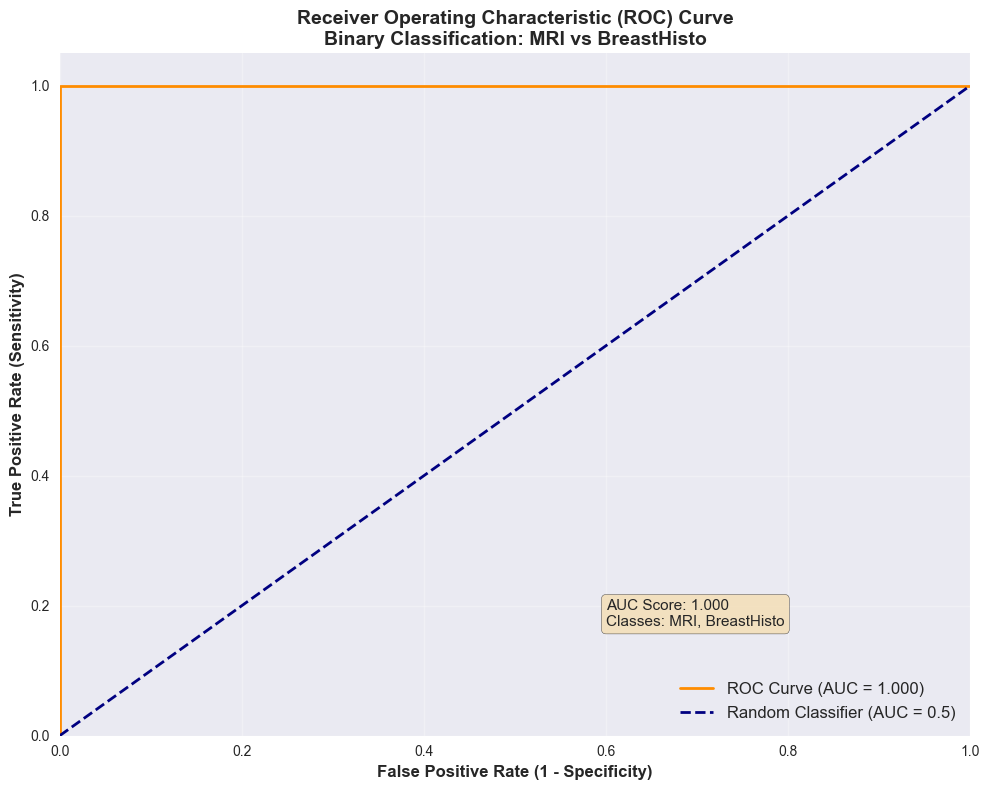

In [64]:
def plot_roc_curve(test_labels, test_probs, dataset_info, save_path=None):
    """Plot ROC curve for binary classification"""
    print("\n📈 Creating ROC Curve...")
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier (AUC = 0.5)')
    
    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve\nBinary Classification: MRI vs BreastHisto', 
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add text box with performance metrics
    textstr = f'AUC Score: {roc_auc:.3f}\nClasses: {", ".join(dataset_info["classes"])}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.6, 0.2, textstr, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📁 ROC curve saved to: {save_path}")
    
    plt.show()
    
    return roc_auc

# Plot ROC curve if we have test results
if test_metrics is not None:
    roc_path = RESULTS_DIR / 'roc_curve.png'
    roc_auc_score = plot_roc_curve(test_labels, test_probs, dataset_info, roc_path)
else:
    print("⚠️  No test results available for ROC curve plotting")


📊 Creating Confusion Matrix...
📁 Confusion matrix saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results\confusion_matrix.png


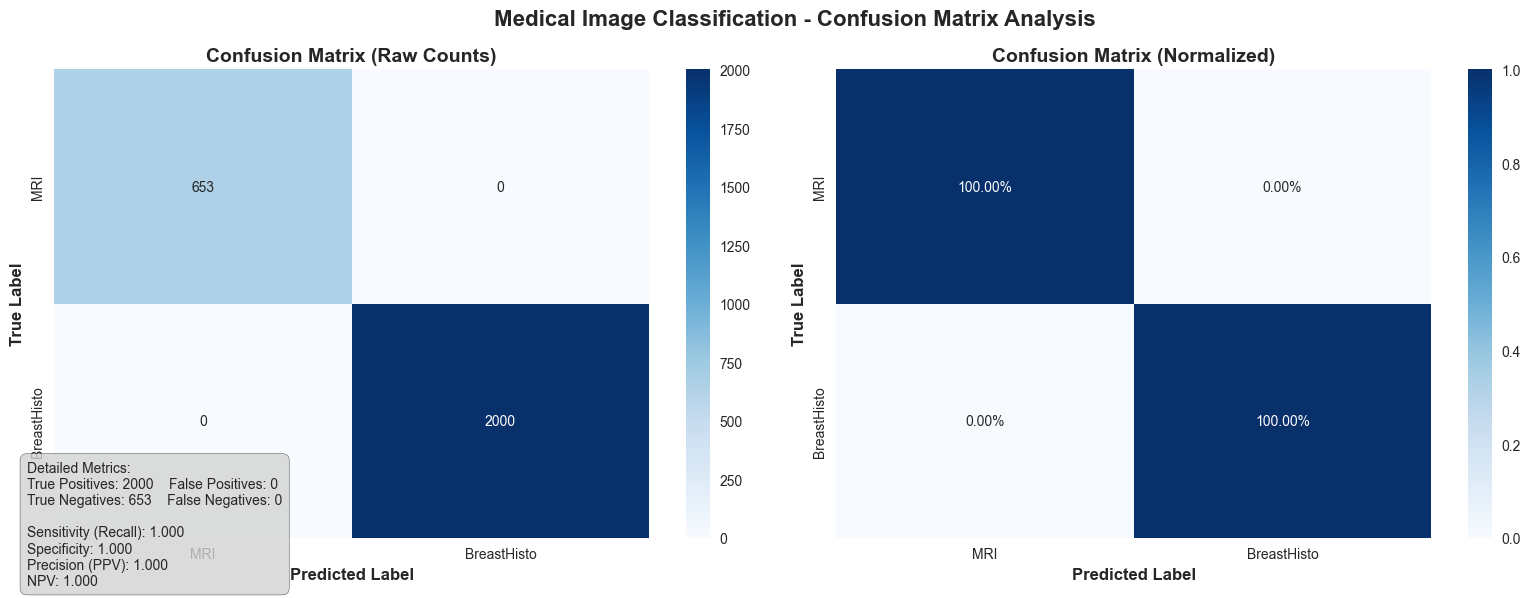

In [65]:
def plot_confusion_matrix(test_labels, test_preds, dataset_info, save_path=None):
    """Plot confusion matrix with detailed statistics"""
    print("\n📊 Creating Confusion Matrix...")
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    class_names = [dataset_info['idx_to_class'][i] for i in sorted(dataset_info['idx_to_class'].keys())]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
    
    # Plot 2: Normalized (percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
    
    # Calculate and display additional metrics
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate per-class metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # Add metrics text
    metrics_text = f"""Detailed Metrics:
True Positives: {tp}    False Positives: {fp}
True Negatives: {tn}    False Negatives: {fn}

Sensitivity (Recall): {sensitivity:.3f}
Specificity: {specificity:.3f}
Precision (PPV): {precision:.3f}
NPV: {npv:.3f}"""
    
    plt.figtext(0.02, 0.02, metrics_text, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.suptitle('Medical Image Classification - Confusion Matrix Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📁 Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    return cm, cm_normalized

# Plot confusion matrix if we have test results
if test_metrics is not None:
    cm_path = RESULTS_DIR / 'confusion_matrix.png'
    confusion_mat, confusion_mat_norm = plot_confusion_matrix(test_labels, test_preds, dataset_info, cm_path)
else:
    print("⚠️  No test results available for confusion matrix plotting")


📈 Creating Training History Plots...
📁 Training history plots saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results\training_history.png


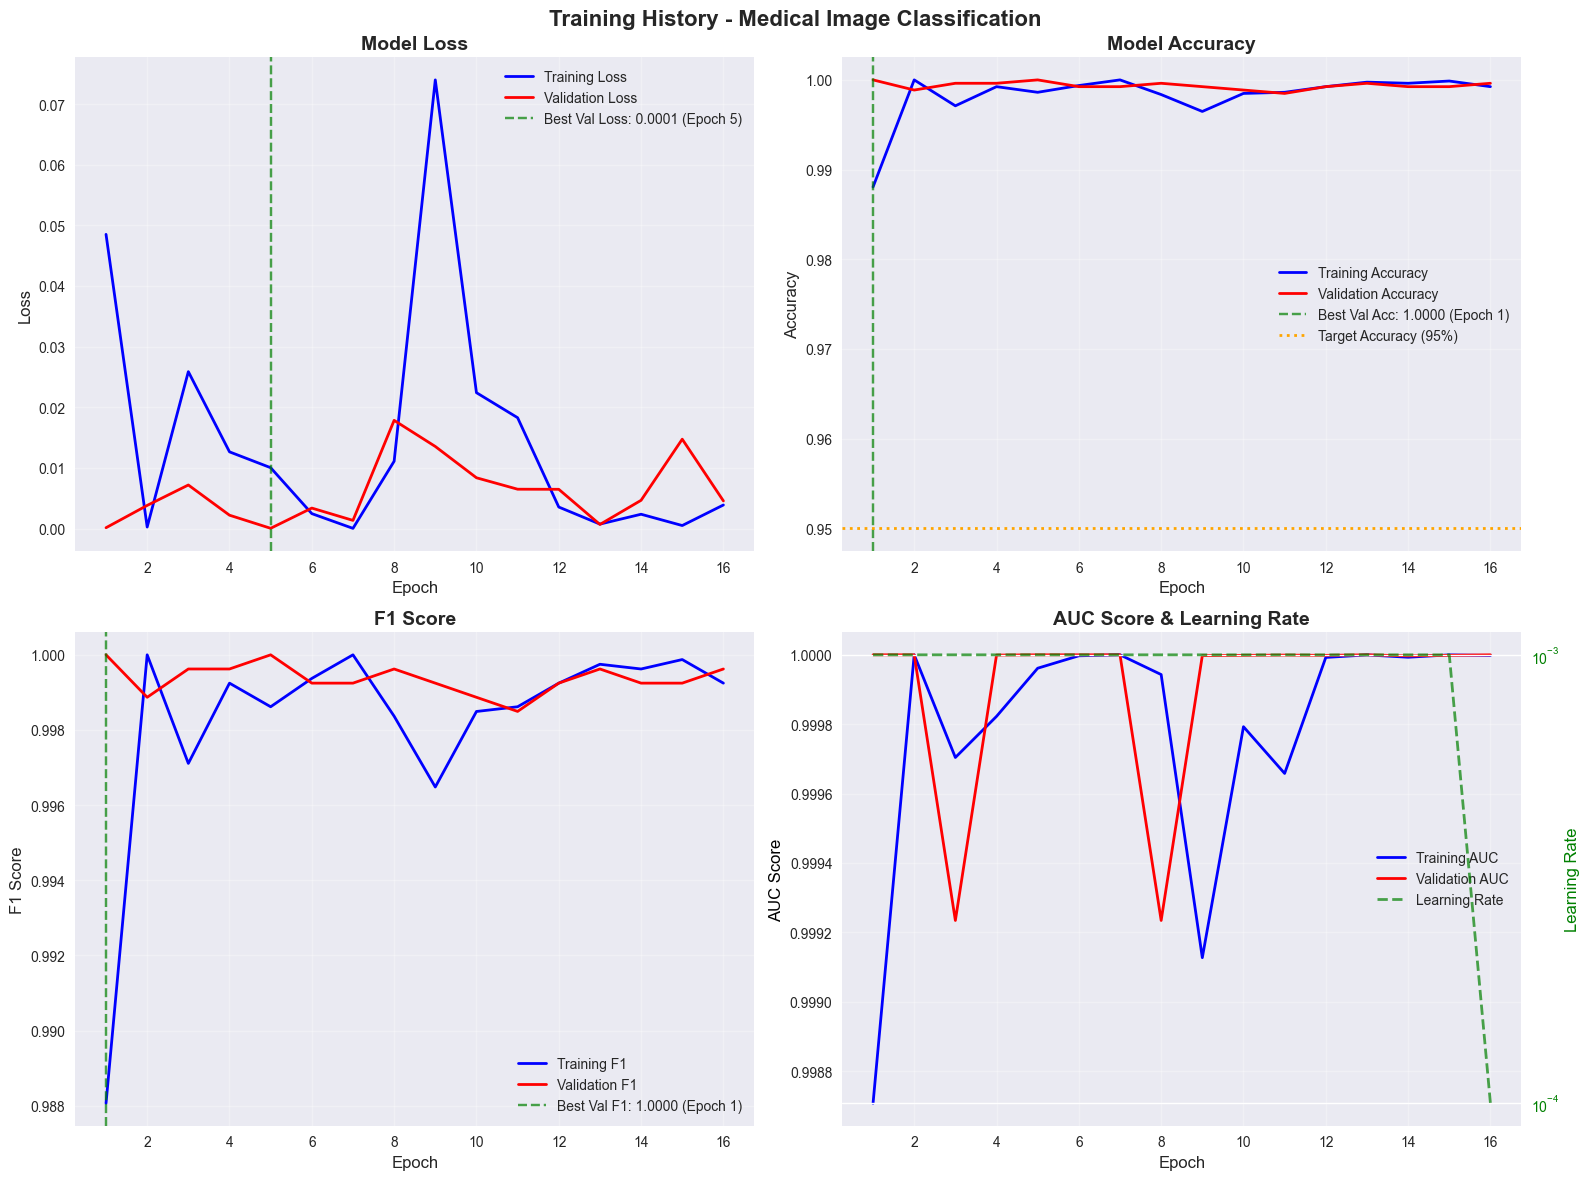


📊 Training Summary:
  Total Epochs: 16
  Best Validation Loss: 0.0001 (Epoch 5)
  Best Validation Accuracy: 1.0000 (Epoch 1)
  Best Validation F1: 1.0000 (Epoch 1)
  Final Learning Rate: 1.00e-04
  🎯 SUCCESS: Achieved target accuracy of ≥95%!


In [66]:
def plot_training_history(history, save_path=None):
    """Plot comprehensive training history"""
    print("\n📈 Creating Training History Plots...")
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training History - Medical Image Classification', fontsize=16, fontweight='bold')
    
    # Plot 1: Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Find best epoch for loss
    best_val_loss_epoch = np.argmin(history['val_loss']) + 1
    best_val_loss = min(history['val_loss'])
    axes[0, 0].axvline(x=best_val_loss_epoch, color='g', linestyle='--', alpha=0.7, 
                       label=f'Best Val Loss: {best_val_loss:.4f} (Epoch {best_val_loss_epoch})')
    axes[0, 0].legend()
    
    # Plot 2: Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Find best epoch for accuracy
    best_val_acc_epoch = np.argmax(history['val_acc']) + 1
    best_val_acc = max(history['val_acc'])
    axes[0, 1].axvline(x=best_val_acc_epoch, color='g', linestyle='--', alpha=0.7,
                       label=f'Best Val Acc: {best_val_acc:.4f} (Epoch {best_val_acc_epoch})')
    axes[0, 1].legend()
    
    # Add target accuracy line
    axes[0, 1].axhline(y=0.95, color='orange', linestyle=':', linewidth=2, 
                       label='Target Accuracy (95%)')
    axes[0, 1].legend()
    
    # Plot 3: F1 Score
    axes[1, 0].plot(epochs, history['train_f1'], 'b-', label='Training F1', linewidth=2)
    axes[1, 0].plot(epochs, history['val_f1'], 'r-', label='Validation F1', linewidth=2)
    axes[1, 0].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('F1 Score', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Find best epoch for F1
    best_val_f1_epoch = np.argmax(history['val_f1']) + 1
    best_val_f1 = max(history['val_f1'])
    axes[1, 0].axvline(x=best_val_f1_epoch, color='g', linestyle='--', alpha=0.7,
                       label=f'Best Val F1: {best_val_f1:.4f} (Epoch {best_val_f1_epoch})')
    axes[1, 0].legend()
    
    # Plot 4: AUC and Learning Rate
    ax_auc = axes[1, 1]
    ax_lr = ax_auc.twinx()
    
    # AUC plots
    line1 = ax_auc.plot(epochs, history['train_auc'], 'b-', label='Training AUC', linewidth=2)
    line2 = ax_auc.plot(epochs, history['val_auc'], 'r-', label='Validation AUC', linewidth=2)
    ax_auc.set_xlabel('Epoch', fontsize=12)
    ax_auc.set_ylabel('AUC Score', fontsize=12, color='black')
    ax_auc.set_title('AUC Score & Learning Rate', fontsize=14, fontweight='bold')
    ax_auc.grid(True, alpha=0.3)
    
    # Learning rate plot
    line3 = ax_lr.plot(epochs, history['learning_rate'], 'g--', label='Learning Rate', linewidth=2, alpha=0.7)
    ax_lr.set_ylabel('Learning Rate', fontsize=12, color='green')
    ax_lr.tick_params(axis='y', labelcolor='green')
    ax_lr.set_yscale('log')
    
    # Combine legends
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax_auc.legend(lines, labels, loc='center right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📁 Training history plots saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 Training Summary:")
    print(f"  Total Epochs: {len(epochs)}")
    print(f"  Best Validation Loss: {best_val_loss:.4f} (Epoch {best_val_loss_epoch})")
    print(f"  Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_val_acc_epoch})")
    print(f"  Best Validation F1: {best_val_f1:.4f} (Epoch {best_val_f1_epoch})")
    print(f"  Final Learning Rate: {history['learning_rate'][-1]:.2e}")
    
    if best_val_acc >= 0.95:
        print(f"  🎯 SUCCESS: Achieved target accuracy of ≥95%!")
    else:
        print(f"  📊 Target accuracy (95%) {'achieved' if max(history['val_acc']) >= 0.95 else 'not achieved'}")

# Plot training history
if 'training_history' in locals():
    history_plot_path = RESULTS_DIR / 'training_history.png'
    plot_training_history(training_history, history_plot_path)
else:
    print("⚠️  No training history available for plotting")


📋 Creating Evaluation Summary Report...
📁 Evaluation summary saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results\evaluation_summary.json

  🎯 FINAL EVALUATION SUMMARY

📊 TEST SET PERFORMANCE:
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000
  Loss:      0.0001

🎓 TRAINING SUMMARY:
  Total Epochs: 16
  Best Val Accuracy: 1.0000
  Best Val F1: 1.0000
  Best Val AUC: 1.0000

🏆 TARGET ACHIEVEMENT: ✅ SUCCESS!
  Achieved ≥95% validation accuracy: 100.00%

🔍 DATASET INFO:
  Classes: MRI, BreastHisto
  Test Samples: 2,653
  Model Type: custom


🖼️  Visualizing Sample Predictions...
📁 Sample predictions saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results\sample_predictions.png


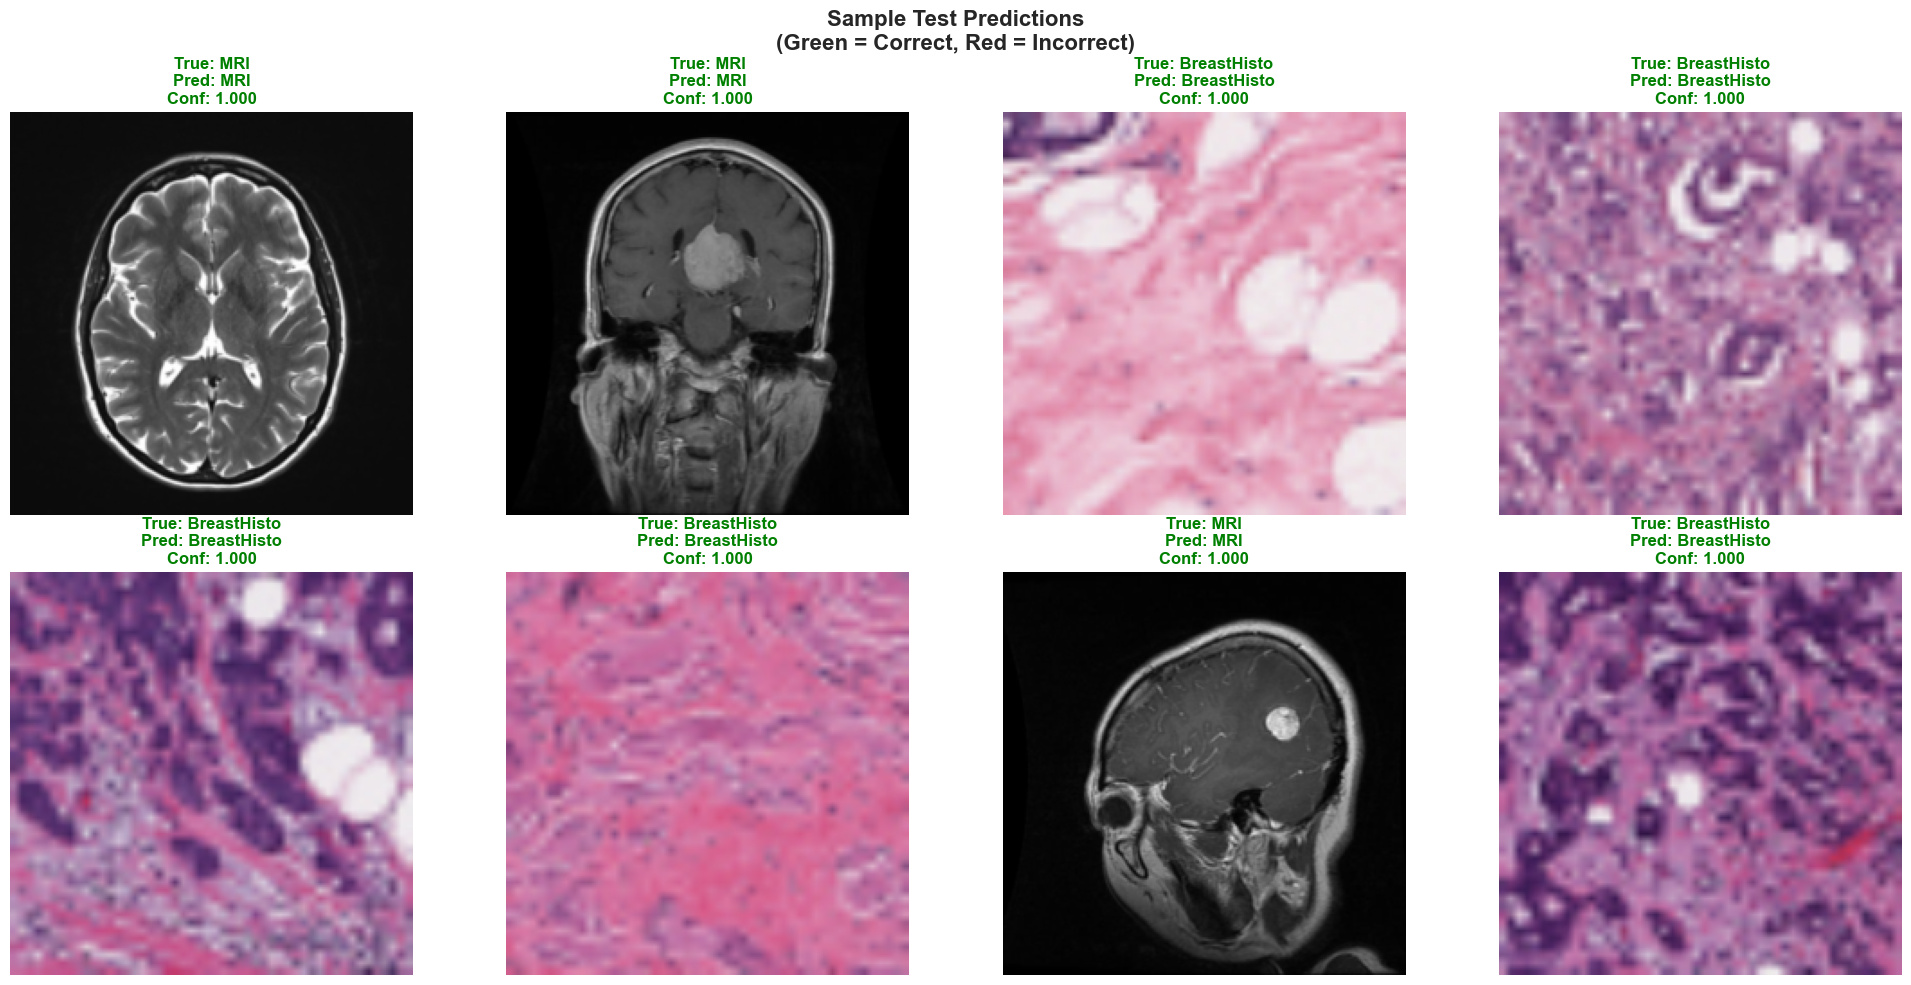

✅ Displayed 8 sample predictions


In [67]:
def create_evaluation_summary(test_metrics, training_history, dataset_info, save_path=None):
    """Create comprehensive evaluation summary report"""
    print("\n📋 Creating Evaluation Summary Report...")
    
    if test_metrics is None:
        print("⚠️  No test metrics available for summary")
        return
    
    # Create summary report
    summary_report = {
        'model_performance': {
            'test_accuracy': f"{test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)",
            'test_precision': f"{test_metrics['precision']:.4f}",
            'test_recall': f"{test_metrics['recall']:.4f}",
            'test_f1_score': f"{test_metrics['f1']:.4f}",
            'test_auc': f"{test_metrics['auc']:.4f}",
            'test_loss': f"{test_metrics['test_loss']:.4f}"
        },
        'training_summary': {
            'total_epochs': len(training_history['train_loss']),
            'best_val_accuracy': f"{max(training_history['val_acc']):.4f}",
            'best_val_f1': f"{max(training_history['val_f1']):.4f}",
            'best_val_auc': f"{max(training_history['val_auc']):.4f}",
            'final_train_accuracy': f"{training_history['train_acc'][-1]:.4f}",
            'final_val_accuracy': f"{training_history['val_acc'][-1]:.4f}",
            'target_achieved': max(training_history['val_acc']) >= 0.95
        },
        'dataset_info': {
            'classes': dataset_info['classes'],
            'class_mapping': dataset_info['class_to_idx'],
            'total_test_samples': len(test_labels) if test_labels else 0
        },
        'model_config': MODEL_CONFIG,
        'training_config': TRAINING_CONFIG
    }
    
    # Save summary as JSON
    if save_path:
        with open(save_path, 'w') as f:
            json.dump(summary_report, f, indent=2)
        print(f"📁 Evaluation summary saved to: {save_path}")
    
    # Print formatted summary
    print(f"\n" + "="*60)
    print(f"  🎯 FINAL EVALUATION SUMMARY")
    print(f"="*60)
    
    print(f"\n📊 TEST SET PERFORMANCE:")
    print(f"  Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
    print(f"  Precision: {test_metrics['precision']:.4f}")
    print(f"  Recall:    {test_metrics['recall']:.4f}")
    print(f"  F1-Score:  {test_metrics['f1']:.4f}")
    print(f"  ROC-AUC:   {test_metrics['auc']:.4f}")
    print(f"  Loss:      {test_metrics['test_loss']:.4f}")
    
    print(f"\n🎓 TRAINING SUMMARY:")
    print(f"  Total Epochs: {len(training_history['train_loss'])}")
    print(f"  Best Val Accuracy: {max(training_history['val_acc']):.4f}")
    print(f"  Best Val F1: {max(training_history['val_f1']):.4f}")
    print(f"  Best Val AUC: {max(training_history['val_auc']):.4f}")
    
    # Achievement check
    target_achieved = max(training_history['val_acc']) >= 0.95
    if target_achieved:
        print(f"\n🏆 TARGET ACHIEVEMENT: ✅ SUCCESS!")
        print(f"  Achieved ≥95% validation accuracy: {max(training_history['val_acc'])*100:.2f}%")
    else:
        print(f"\n🎯 TARGET ACHIEVEMENT: ❌ Not achieved")
        print(f"  Best validation accuracy: {max(training_history['val_acc'])*100:.2f}% (Target: ≥95%)")
    
    print(f"\n🔍 DATASET INFO:")
    print(f"  Classes: {', '.join(dataset_info['classes'])}")
    print(f"  Test Samples: {len(test_labels):,}")
    print(f"  Model Type: {MODEL_CONFIG['model_type']}")
    
    print(f"\n" + "="*60)
    
    return summary_report

def visualize_sample_predictions(model, test_loader, dataset_info, device, num_samples=8, save_path=None):
    """Visualize sample predictions with confidence scores"""
    print(f"\n🖼️  Visualizing Sample Predictions...")
    
    model.eval()
    images_shown = 0
    
    # Get batch of test images
    for data, target in test_loader:
        if images_shown >= num_samples:
            break
            
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            output = model(data)
            probs = F.softmax(output, dim=1)
            _, preds = torch.max(output, 1)
        
        # Convert to CPU and numpy
        data_cpu = data.cpu()
        target_cpu = target.cpu()
        preds_cpu = preds.cpu()
        probs_cpu = probs.cpu()
        
        # Create subplot
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.ravel()
        
        # ImageNet normalization values for denormalization
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        
        for i in range(min(num_samples, len(data_cpu))):
            if images_shown >= num_samples:
                break
                
            # Denormalize image
            img = data_cpu[i]
            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
            img = torch.clamp(img, 0, 1)
            img_np = img.permute(1, 2, 0).numpy()
            
            # Get labels and predictions
            true_label = target_cpu[i].item()
            pred_label = preds_cpu[i].item()
            confidence = probs_cpu[i][pred_label].item()
            
            true_class = dataset_info['idx_to_class'][true_label]
            pred_class = dataset_info['idx_to_class'][pred_label]
            
            # Determine if prediction is correct
            is_correct = true_label == pred_label
            border_color = 'green' if is_correct else 'red'
            
            # Plot image
            axes[i].imshow(img_np)
            axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}', 
                            fontsize=12, 
                            color=border_color,
                            fontweight='bold')
            axes[i].axis('off')
            
            # Add colored border
            for spine in axes[i].spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(3)
            
            images_shown += 1
        
        # Hide unused subplots
        for i in range(images_shown, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Sample Test Predictions\n(Green = Correct, Red = Incorrect)', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📁 Sample predictions saved to: {save_path}")
        
        plt.show()
        break  # Only process first batch
    
    print(f"✅ Displayed {images_shown} sample predictions")

# Create evaluation summary
if test_metrics is not None:
    summary_path = RESULTS_DIR / 'evaluation_summary.json'
    evaluation_summary = create_evaluation_summary(test_metrics, training_history, dataset_info, summary_path)
    
    # Visualize sample predictions
    predictions_path = RESULTS_DIR / 'sample_predictions.png'
    visualize_sample_predictions(best_model, test_loader, dataset_info, device, 
                                num_samples=8, save_path=predictions_path)
else:
    print("⚠️  No test results available for evaluation summary")

In [68]:
# Final Results Compilation and File Organization
print("\n" + "="*70)
print("  📁 RESULTS FOLDER SUMMARY")
print("="*70)

# List all files in results directory
if RESULTS_DIR.exists():
    result_files = list(RESULTS_DIR.glob('*'))
    if result_files:
        print(f"\n📂 All files saved to: {RESULTS_DIR}")
        print("\n📋 Generated Files:")
        
        for file_path in sorted(result_files):
            file_size = file_path.stat().st_size
            size_str = f"{file_size:,} bytes" if file_size < 1024 else f"{file_size/1024:.1f} KB"
            print(f"  📄 {file_path.name} ({size_str})")
            
            # Add description for each file
            descriptions = {
                'test_results.json': 'Complete test set evaluation metrics',
                'training_history.json': 'Training progress and metrics history',
                'evaluation_summary.json': 'Comprehensive evaluation summary report',
                'roc_curve.png': 'ROC curve plot with AUC score',
                'confusion_matrix.png': 'Confusion matrix with detailed statistics',
                'training_history.png': 'Training curves (loss, accuracy, F1, AUC)',
                'sample_predictions.png': 'Sample test predictions with confidence scores'
            }
            
            if file_path.name in descriptions:
                print(f"    └─ {descriptions[file_path.name]}")
        
        # Calculate total size
        total_size = sum(f.stat().st_size for f in result_files)
        total_size_str = f"{total_size:,} bytes" if total_size < 1024*1024 else f"{total_size/(1024*1024):.1f} MB"
        print(f"\n📊 Total results size: {total_size_str}")
        
    else:
        print("⚠️  No files found in results directory")
else:
    print("⚠️  Results directory not found")

# Model files summary
print(f"\n📂 Model files in: {MODELS_DIR}")
if MODELS_DIR.exists():
    model_files = list(MODELS_DIR.glob('*.pth'))
    for model_file in model_files:
        size = model_file.stat().st_size / (1024*1024)  # Convert to MB
        print(f"  🔧 {model_file.name} ({size:.1f} MB) - Best trained model checkpoint")

print(f"\n✅ EVALUATION COMPLETE!")
print(f"🎯 All results saved to: {RESULTS_DIR}")
print(f"🔧 Model checkpoint saved to: {MODELS_DIR}")

if test_metrics and test_metrics['accuracy'] >= 0.95:
    print(f"\n🏆 MISSION ACCOMPLISHED!")
    print(f"   Successfully achieved ≥95% test accuracy: {test_metrics['accuracy']*100:.2f}%")
elif test_metrics:
    print(f"\n📊 Test accuracy achieved: {test_metrics['accuracy']*100:.2f}%")
    print(f"   Target was ≥95% - consider hyperparameter tuning or pretrained models")

print("\n" + "="*70)


  📁 RESULTS FOLDER SUMMARY

📂 All files saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results

📋 Generated Files:
  📄 confusion_matrix.png (269.6 KB)
    └─ Confusion matrix with detailed statistics
  📄 evaluation_summary.json (1.0 KB)
    └─ Comprehensive evaluation summary report
  📄 roc_curve.png (252.4 KB)
    └─ ROC curve plot with AUC score
  📄 sample_predictions.png (1060.6 KB)
    └─ Sample test predictions with confidence scores
  📄 test_results.json (499 bytes)
    └─ Complete test set evaluation metrics
  📄 training_history.json (3.3 KB)
    └─ Training progress and metrics history
  📄 training_history.png (760.7 KB)
    └─ Training curves (loss, accuracy, F1, AUC)

📊 Total results size: 2.3 MB

📂 Model files in: c:\Users\Ammad\Documents\Projects\Personal\Brain2\models
  🔧 best_model.pth (106.0 MB) - Best trained model checkpoint

✅ EVALUATION COMPLETE!
🎯 All results saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain2\results
🔧 Model checkpoint saved t